In [1]:
library(dplyr)
library(tibble)
library(tidyr)

library(Biobase)
library(pvca)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
  

In [2]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [3]:
# source files
src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../relapse_prediction/R/batch.R
Sourced file: ../../relapse_prediction/R/calc.R
Sourced file: ../../relapse_prediction/R/gpca.R
Sourced file: ../../relapse_prediction/R/misc.R
Sourced file: ../../relapse_prediction/R/normalise.R
Sourced file: ../../relapse_prediction/R/plot.R
Sourced file: ../../relapse_prediction/R/predict.R
Sourced file: ../../relapse_prediction/R/rvp.R
Sourced file: ../../relapse_prediction/R/subset.R
Sourced file: ../../relapse_prediction/R/utils.R


In [4]:
quantify_batch <- function(X, metadata) {
  batch <- metadata[colnames(X), 'batch']
  class <- metadata[colnames(X), 'class']

  rvp <- RVP(t(X), batch, class)
  gpca <- gPCA.batchdetect(t(X), batch)
    
  # create expressionset from biobase package
  meta_metadata <- data.frame(labelDescription = colnames(metadata))
  pheno_data <- new(
    "AnnotatedDataFrame",
    data = metadata, varMetadata = meta_metadata
  )
  eset <- ExpressionSet(assayData = as.matrix(X), phenoData = pheno_data)
  pvca_obj <- pvcaBatchAssess(eset, c('batch', 'class'), 0.6)
  var_pcts <- as.vector(pvca_obj$dat)
  names(var_pcts) <- as.vector(pvca_obj$label)

  c(
    gpca = gpca$delta,
    pvca = var_pcts['batch'],
    rvp = rvp
  )
}

# MAQC

In [6]:
file_maqc <- "../data/MAQC-I/processed/mas5_original-ref.tsv"
raw_maqc <- read.table(file_maqc, sep = "\t", header = T, row.names = 1)

# MAQC metadata
# Class A - Universal Human Reference RNA (UHRR)
# Class B - Human Brain Reference RNA (HBRR)
batch_info <- as.factor(rep(1:6, each = 10))
class_info <- rep(rep(LETTERS[1:2], each = 5), 6)
metadata_maqc <- data.frame(
  batch_info, class_info,
  row.names = colnames(raw_maqc)
)

# SCALE->REMOVE->FILTER->LOG
scaled_maqc <- raw_maqc %>%
  normaliseMeanScaling()

log_maqc <- scaled_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata_maqc) %>%
  log2_transform()

AFX_1_A1 AFX_1_A2 AFX_1_A3 AFX_1_A4 AFX_1_A5 AFX_1_B1 
6.167267 4.921776 6.064782 5.998307 5.594024 6.396092 
[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


In [29]:
colnames(metadata_maqc)

[1] "AFX_1_A1" "AFX_1_A2" "AFX_1_A3" "AFX_1_A4" "AFX_1_A5" "AFX_1_B1"
 [7] "AFX_1_B2" "AFX_1_B3" "AFX_1_B4" "AFX_1_B5" "AFX_2_A1" "AFX_2_A2"
[13] "AFX_2_A3" "AFX_2_A4" "AFX_2_A5" "AFX_2_B1" "AFX_2_B2" "AFX_2_B3"
[19] "AFX_2_B4" "AFX_2_B5" "AFX_3_A1" "AFX_3_A2" "AFX_3_A3" "AFX_3_A4"
[25] "AFX_3_A5" "AFX_3_B1" "AFX_3_B2" "AFX_3_B3" "AFX_3_B4" "AFX_3_B5"
[31] "AFX_4_A1" "AFX_4_A2" "AFX_4_A3" "AFX_4_A4" "AFX_4_A5" "AFX_4_B1"
[37] "AFX_4_B2" "AFX_4_B3" "AFX_4_B4" "AFX_4_B5" "AFX_5_A1" "AFX_5_A2"
[43] "AFX_5_A3" "AFX_5_A4" "AFX_5_A5" "AFX_5_B1" "AFX_5_B2" "AFX_5_B3"
[49] "AFX_5_B4" "AFX_5_B5" "AFX_6_A1" "AFX_6_A2" "AFX_6_A3" "AFX_6_A4"
[55] "AFX_6_A5" "AFX_6_B1" "AFX_6_B2" "AFX_6_B3" "AFX_6_B4" "AFX_6_B5"

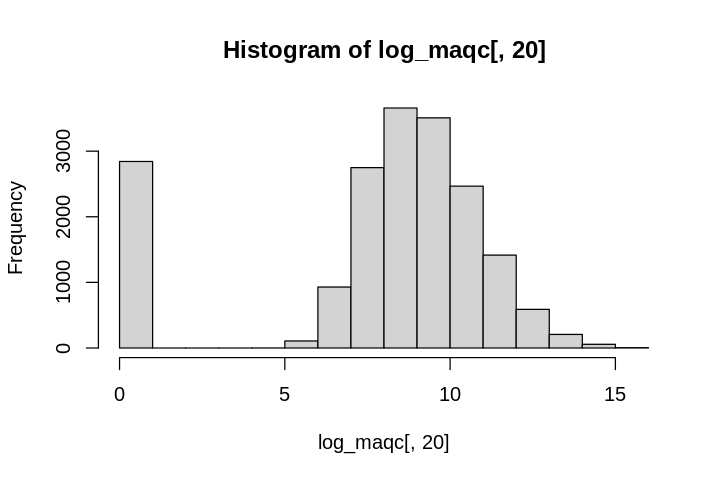

In [68]:
hist(log_maqc[, 20])

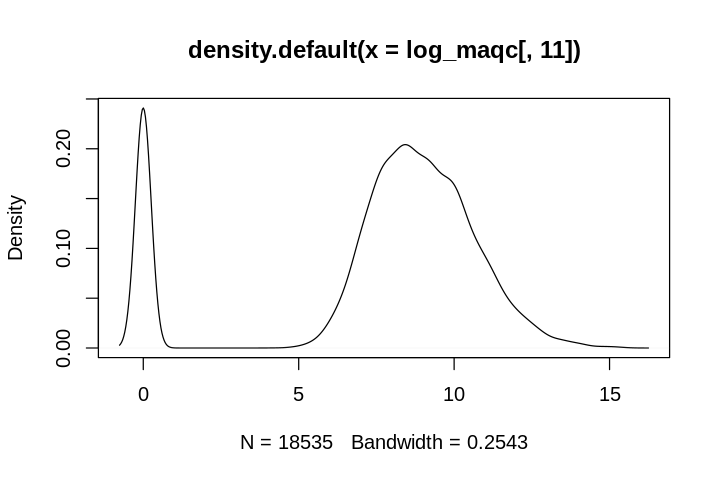

In [32]:
plot(density(log_maqc[,11]))

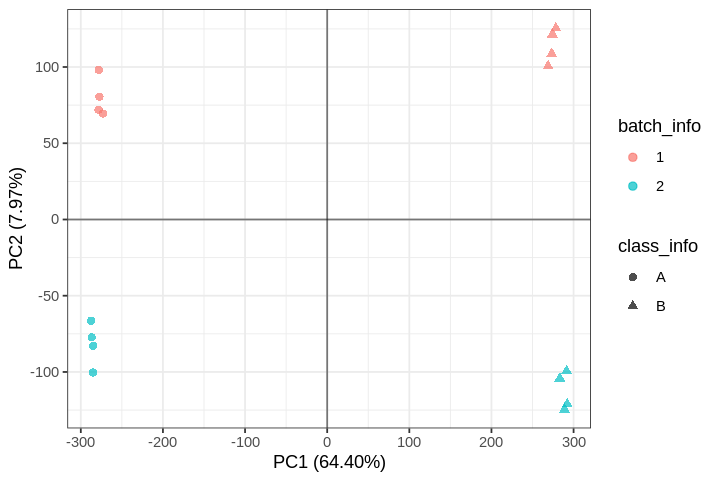

In [80]:
ggplot_pca(
  maqc_bal, metadata_maqc,
  col = 'batch_info', pch = 'class_info'
)

In [33]:
# log_nozero <- log_maqc[rowSums(log_maqc == 0) == 0, ]

## Investigate: Batch effects

In [111]:
feat_vars <- apply(log_maqc, 1, var)

In [109]:
i <- 1
idx <- order(-feat_vars)
print(feat_vars[idx[i]])

203540_at 
 55.56472 


[1] 236


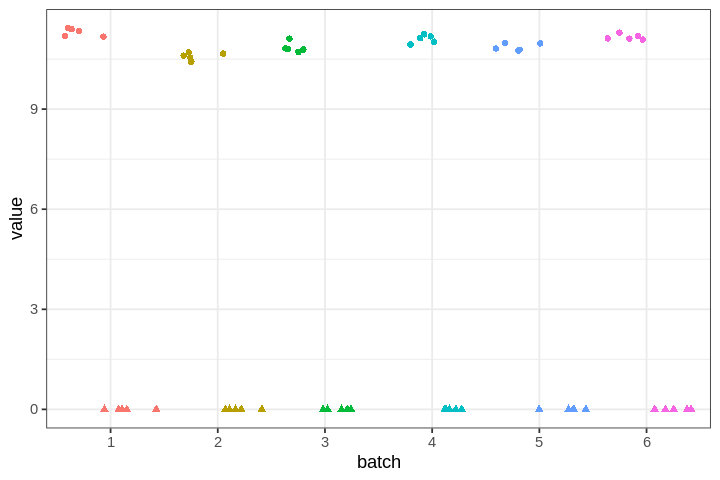

In [345]:
i <- i + 1
print(i)
feature <- data.frame(
  value = as.vector(data.matrix(log_maqc[idx[i], ])),
  batch = metadata_maqc$batch_info,
  class = metadata_maqc$class_info
)
ggplot(feature) +
  geom_point(
    aes(x = batch, y = value, pch = class, col = batch),
    position = position_jitterdodge(jitter.width = 2),
    show.legend = FALSE
  )

# Measuring batch effects
- Different batch-class imbalance
- No batch effects
- Different magnitude of batch effects when there is batch-class imbalance
- Measure when there is different number of features
- Different batch sizes

### Comparisons
- gPCA delta: 0-1 (proportion of variance)
    - Weak in quantifying small amounts of batch effects?
    - Problems when there is no batch effects but there is class imbalance

In [71]:
# subsetting maqc
maqc_bal <- log_maqc[, c(1:4, 6:9, 11:14, 16:19)]
maqc_imbal <- log_maqc[, c(1:3, 6:10, 11:15, 16:18)]
maqc_fakebatch <- log_maqc[, c(1:4, 6:9)]

In [72]:
fake_metadata <- metadata_maqc[colnames(maqc_fakebatch), ]

In [73]:
fake_metadata[3, 1] <- 2
fake_metadata[6, 1] <- 1

In [74]:
head(metadata_maqc)

,batch_info,class_info
,<fct>,<chr>
AFX_1_A1,1,A
AFX_1_A2,1,A
AFX_1_A3,1,A
AFX_1_A4,1,A
AFX_1_A5,1,A
AFX_1_B1,1,B


#### Comparison: Metrics

In [156]:
quantify_batch(maqc_fakebatch, fake_metadata)

[1] 1 1 1 2 1 2 2 2
Levels: 1 2 3 4 5 6
[1] A A A A B B B B
Levels: A B
Split into classes: A B


$pct_v1
[1] 0.2158695

$pct_v2
[1] "0.3273; 0.3258"

$pct_v3
[1] 0.08639798

$batch_dist
[1] 59785.32

$gpca_delta
[1] 0.85822

$gpca_pvalue
[1] 0.206

#### PVCA

In [177]:
# create expressionset from biobase package
meta_metadata <- data.frame(labelDescription = colnames(metadata))
pheno_data <- new("AnnotatedDataFrame", data = metadata, varMetadata = meta_metadata)
maqc_eset <- ExpressionSet(assayData = as.matrix(log_maqc), phenoData = pheno_data)

In [178]:
eset <- maqc_eset[, c(1:4, 6:9, 11:14, 16:19)]

In [172]:
# create expressionset from biobase package
print(fake_metadata)
fake_pheno_data <- new("AnnotatedDataFrame", data = fake_metadata, varMetadata = meta_metadata)
fakebatch_eset <- ExpressionSet(assayData = as.matrix(maqc_fakebatch), phenoData = fake_pheno_data)

         batch_info class_info
AFX_1_A1          1          A
AFX_1_A2          1          A
AFX_1_A3          2          A
AFX_1_A4          2          A
AFX_1_B1          1          B
AFX_1_B2          1          B
AFX_1_B3          2          B
AFX_1_B4          2          B


In [191]:
pvca_obj <- pvcaBatchAssess(eset, c('batch_info', 'class_info'), 0.6)
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))

singular fit
singular fit
singular fit


[1] "batch_info:class_info" "class_info"            "batch_info"           
[4] "resid"                


[1] "0.0492; 0.8484; 0.1012; 0.0012"

## Ma-Spore ALL

In [50]:
# Metadata
METADATA_SID <- "../../relapse_prediction/data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../../relapse_prediction/data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../../relapse_prediction/data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [51]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
levels(metadata_sid$label) <- c('Remission', 'Relapse')
metadata_sid$batch_info <- as.factor(metadata_sid$batch_info) 
metadata_pid$label <- as.factor(metadata_pid$label)
levels(metadata_pid$label) <- c('Remission', 'Relapse')

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] "No. of probesets removed = 6321"


In [364]:
metadata_yeoh <- metadata_sid[colnames(yeoh), ]
metadata_telaml1 <- subset(
  metadata_sid,
  subtype == 'TEL-AML1' &
  label == 'Remission' &
  batch_info %in% c(2, 9)
)

In [751]:
rvp_sel <- RVP(t(yeoh), metadata_yeoh$batch_info, metadata_yeoh$class_info)
rvp_all <- RVP(t(yeoh_allps), metadata_yeoh$batch_info, metadata_yeoh$class_info)

All samples are from the same batch!

All samples are from the same batch!



In [755]:
del_feat <- setdiff(rownames(yeoh_allps), rownames(yeoh))
yeoh_del <- yeoh_allps[del_feat, ]

In [53]:
bal_sids <- get_sid(c(
  'P022', 'P023', 'P024', 'P025',
  'P099', 'P106', 'P120', 'P121'
))
imbal_sids <- c(
  'P022_D0', 'P023_D0', 'P024_D0', 'P025_D0', 'P026_D0', 'P022_D8', 'P023_D8', 'P024_D8',
  'P099_D0', 'P106_D0', 'P120_D0', 'P099_D8', 'P106_D8', 'P120_D8', 'P121_D8', 'P127_D8'
)

In [54]:
yeoh_bal <- yeoh[, bal_sids]
yeoh_imbal <- yeoh[, imbal_sids]

In [55]:
fakebatch_sids <- get_sid(c(
  'P022', 'P023', 'P024', 'P025',
  'P026', 'P027', 'P035', 'P036'
))
yeoh_fakebatch <- yeoh[, fakebatch_sids]

In [56]:
fake_metadata <- metadata_sid[fakebatch_sids, ]
fake_metadata1 <- fake_metadata
fake_metadata2 <- fake_metadata
fake_metadata1[c(1:4, 9:12), 1] <- 1
fake_metadata2[c(1:6, 11:16), 1] <- 1

In [356]:
table(metadata_sid$batch_info)


 1  2  3  4  5  6  7  8  9 10 
39 75 42 31 43 33 27 55 60 56 

In [604]:
metadata_yeoh1 <- subset(metadata_yeoh, batch_info %in% c(2, 9))
pidx <- rownames(metadata_yeoh1)

In [368]:
head(metadata_sid)

,batch_info,class_info,subtype,label
,<fct>,<chr>,<chr>,<fct>
P001_D0,3,D0,T-ALL,Remission
P004_D0,2,D0,T-ALL,Remission
P005_D0,2,D0,T-ALL,Remission
P007_D0,2,D0,T-ALL,Relapse
P008_D0,3,D0,T-ALL,Remission
P009_D0,1,D0,T-ALL,Remission


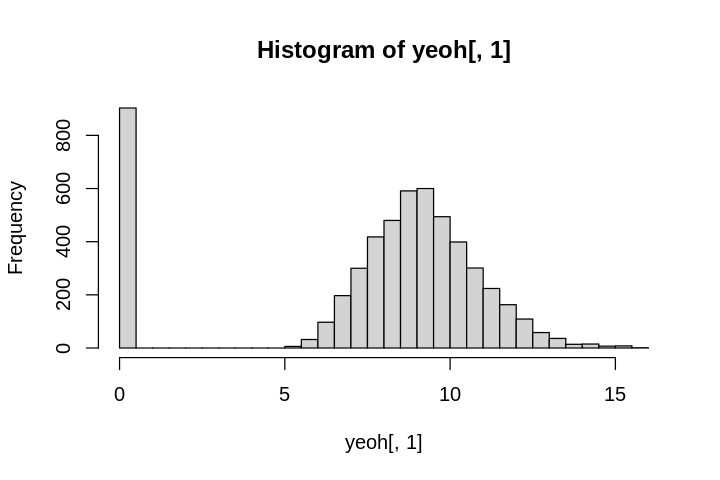

In [750]:
hist(yeoh[,1], breaks = 30)

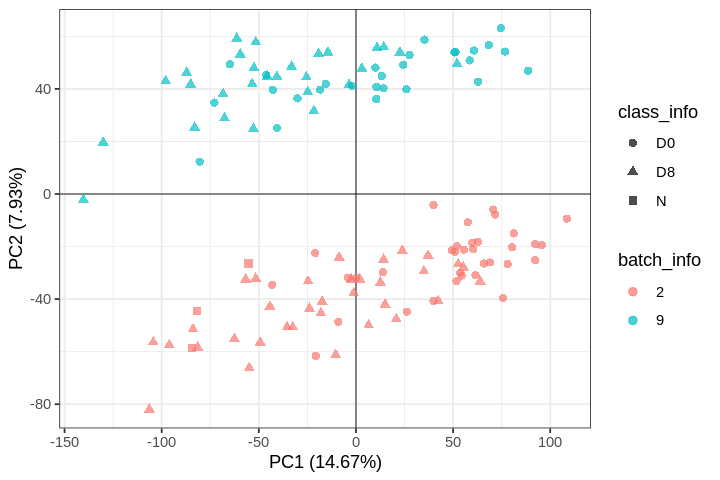

In [605]:
ggplot_pca(yeoh[, pidx], metadata_yeoh1, col = 'batch_info', pch = 'class_info')

[1] 581


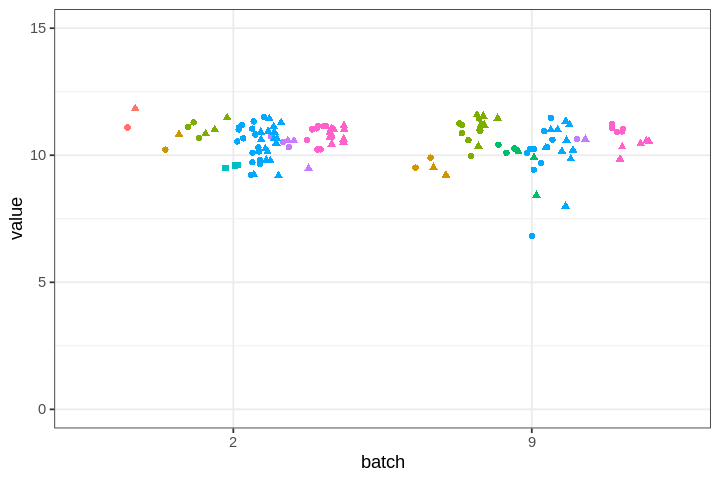

In [739]:
i <- i + 1
print(i)
feature <- data.frame(
  value = as.vector(data.matrix(yeoh[i, pidx])),
  batch = metadata_yeoh1$batch_info,
  class = metadata_yeoh1$class_info,
  subtype = metadata_yeoh1$subtype
)
ggplot(feature) +
  geom_point(
    aes(x = batch, y = value, col = subtype, pch = class),
    position = position_jitterdodge(jitter.width = .1),
    show.legend = FALSE
  ) +
  ylim(0, 15)

## Feature selection

## PCA

In [79]:
table(metadata_sid$batch_info, metadata_sid$class_info)

    
     D0 D8  N
  1  19 20  0
  2  38 34  3
  3  21 21  0
  4  16 15  0
  5   1  0 42
  6  16 17  0
  7  13 14  0
  8  28 27  0
  9  28 32  0
  10 28 28  0

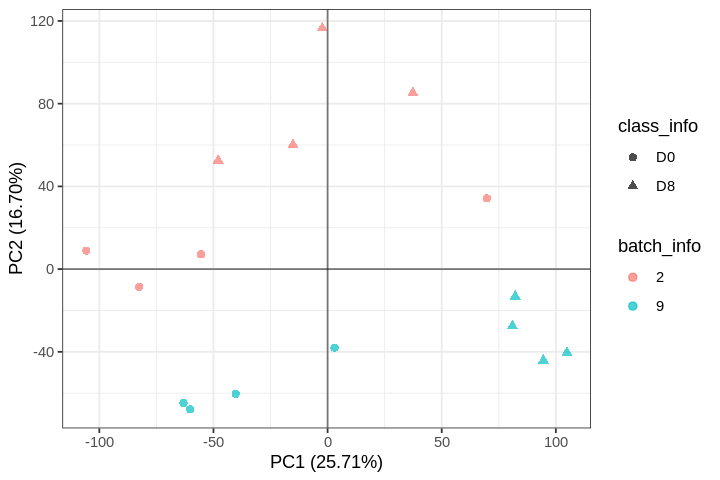

In [58]:
ggplot_pca(yeoh_bal, metadata_sid, col = 'batch_info', pch = 'class_info')

In [748]:
rbinom(100, 1, .8)

[1] 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 [75] 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [50]:
metrics1 <- quantify_batch(yeoh_bal, metadata_sid)

 [1] 2 2 2 2 9 9 9 9 2 2 2 2 9 9 9 9
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D0 D0 D0 D8 D8 D8 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [51]:
metrics2 <- quantify_batch(yeoh_imbal, metadata_sid)

 [1] 2 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D8 D8 D8 D0 D0 D0 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [53]:
metrics3 <- quantify_batch(yeoh_fakebatch, fake_metadata1)

 [1] 1 1 1 1 2 2 2 2 1 1 1 1 2 2 2 2
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D0 D0 D0 D8 D8 D8 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [54]:
metrics4 <- quantify_batch(yeoh_fakebatch, fake_metadata2)

 [1] 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D0 D0 D0 D8 D8 D8 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [68]:
metrics4

$pct_v1
[1] 0.081756

$pct_v2
[1] "0.1567; 0.1732"

$pct_v3
[1] 0.1416216

$batch_dist
[1] 23122.41

$gpca_delta
[1] 0.5451259

$gpca_pvalue
[1] 0.19

# PVCA

In [58]:
metadata_yeoh <- metadata_sid[colnames(yeoh), ]

In [59]:
# create expressionset from biobase package
meta_metadata <- data.frame(labelDescription = colnames(metadata_sid))
pheno_data <- new("AnnotatedDataFrame", data = metadata_yeoh, varMetadata = meta_metadata)
yeoh_eset <- ExpressionSet(assayData = as.matrix(yeoh), phenoData = pheno_data)

In [69]:
# TODO
eset <- yeoh_eset[, imbal_sids]

In [70]:
pvca_obj <- pvcaBatchAssess(eset, c('batch_info', 'class_info'), 0.6)
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))

singular fit
singular fit
singular fit
singular fit
singular fit


[1] "batch_info:class_info" "class_info"            "batch_info"           
[4] "resid"                


[1] "0.1864; 0.2284; 0.1907; 0.3944"

In [75]:
# create expressionset from biobase package
print(fake_metadata2)
fake_pheno_data <- new("AnnotatedDataFrame", data = fake_metadata2, varMetadata = meta_metadata)
fakebatch_eset <- ExpressionSet(assayData = as.matrix(yeoh_fakebatch), phenoData = fake_pheno_data)

        batch_info class_info  subtype     label
P022_D0          1         D0 TEL-AML1 Remission
P023_D0          1         D0 TEL-AML1 Remission
P024_D0          1         D0 TEL-AML1 Remission
P025_D0          1         D0 TEL-AML1 Remission
P026_D0          1         D0 TEL-AML1 Remission
P027_D0          1         D0 TEL-AML1 Remission
P035_D0          2         D0 TEL-AML1 Remission
P036_D0          2         D0 TEL-AML1 Remission
P022_D8          2         D8 TEL-AML1 Remission
P023_D8          2         D8 TEL-AML1 Remission
P024_D8          1         D8 TEL-AML1 Remission
P025_D8          1         D8 TEL-AML1 Remission
P026_D8          1         D8 TEL-AML1 Remission
P027_D8          1         D8 TEL-AML1 Remission
P035_D8          1         D8 TEL-AML1 Remission
P036_D8          1         D8 TEL-AML1 Remission


In [76]:
pvca_obj <- pvcaBatchAssess(fakebatch_eset, c('batch_info', 'class_info'), 0.6)
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))

singular fit
singular fit
singular fit
singular fit
singular fit
singular fit


[1] "batch_info:class_info" "class_info"            "batch_info"           
[4] "resid"                


[1] "0.0783; 0.2255; 0.0738; 0.6225"

In [61]:
# table(metadata_sid[colnames(yeoh_imbal), c('batch_info', 'class_info')])

# Westlake
- Metrics used on data that is not log-transformed

In [112]:
# # regenerate fake batch data
# file1 <- "../data/westlake-A549_K562/processed/balanced.csv"
# data <- read.table(file1, sep = ",", header = T, row.names = 1)

# file2 <- "../data/westlake-A549_K562/processed/metadata/fake_batch-balanced.csv"
# metadata <- read.table(file2, sep = ",", header = T, row.names = 1)

# fake_batch <- data[, rownames(metadata)]
# file3 <- "../data/westlake-A549_K562/processed/fake_batch.csv"
# write.csv(fake_batch, file3, quote = F)

In [22]:
file1 <- "../data/westlake-A549_K562/processed/severe.csv"
file2 <- "../data/westlake-A549_K562/processed/metadata/severe.csv"

data <- read.table(file1, sep = ",", header = T, row.names = 1)
metadata <- read.table(file2, sep = ",", header = T, row.names = 1)
metadata$machine <- as.factor(metadata$machine)
stopifnot(identical(colnames(data), rownames(metadata)))

In [29]:
rvp <- RVP(t(data), metadata$machine, metadata$class)

In [9]:
ax <- ggplot_pca(data, metadata, col = 'machine', pch = 'class')

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


In [4]:
file <- '~/Dropbox/tmp/westlake-severe.pdf'
ggsave(file, ax, width = 5, height = 3)

ERROR: Error in ggsave(file, ax, width = 5, height = 3): could not find function "ggsave"


In [17]:
sample <- data.frame(
  value = as.numeric(data[1,]),
  batch = metadata$machine,
  class = metadata$class
)

In [20]:
ax <- ggplot(sample) +
  geom_point(
    aes(x = class, y = value, col = batch),
    position = position_jitterdodge()
  )

In [21]:
file <- '~/Dropbox/tmp/rvp-sample.pdf'
ggsave(file, ax, width = 5, height = 3)

# PCA plots

In [41]:
metadata_maqc_bal <- metadata_maqc[colnames(maqc_bal), ]

In [43]:
head(metadata_maqc_bal)

,batch_info,class_info
,<fct>,<chr>
AFX_1_A1,1,A
AFX_1_A2,1,A
AFX_1_A3,1,A
AFX_1_A4,1,A
AFX_1_B1,1,B
AFX_1_B2,1,B


In [45]:
rvp <- RVP(t(maqc_bal), metadata_maqc_bal$batch_info, metadata_maqc_bal$class_info)

In [51]:
maqc_prcomp <- prcomp(t(maqc_bal))
maqc_pca <- maqc_prcomp$x

In [52]:
rvp <- RVP(maqc_pca, metadata_maqc_bal$batch_info, metadata_maqc_bal$class_info)